# Training

Zoals eerder vermeld, zijn er twee basis stappen in machine learning:
1. Model training
2. Model inference

(target-training)=
Op het moment dat we een model hebben gedefinieerd, willen we de parameters aan de hand van de beschikbare data schatten. Dat doen we door het gepaste leeralgoritme toe te passen.
Dit noemen we **model training**.
Een **getraind model is een model waarvan de parameters geschat zijn met behulp van een wel bepaalde training dataset en optimalisatie-algoritme**.

(target-inference)=
**Pas als het model getraind is, kan het gebruikt worden om nieuwe data te voorspellen op basis van de geleerde patronen. Die stap heet _model inference_**.

:::{warning}
Het is niet omdat we een getraind model hebben, dat dit automatisch betekent dat het de juiste patronen geleerd heeft en bruikbaar is om voorspellingen te doen - dit is het onderwerp van {ref}`model evaluatie <target-evaluation>`.
:::

## Leeralgoritme
(target-learning-algorithm)=
**Een leer- of optimalisatie-algoritme heeft als doel om de optimale waarde voor een parameter te vinden, gegeven ons model (van de datageneratie) en de beschikbare data.**
Bij het uitvoeren van het leeralgoritme gebeurt dus het eigenlijke leren in ML. Ook hier zijn vaak verschillende keuzes aan de orde.
Daarbij moeten we (a) de effectiviteit om optimale parameterwaarden te vinden en (b) de computationele efficiëntie tegen elkaar afwegen.  
  
De keuze van het algoritme hangt samen met het type model (lineair, neuraal netwerk, random forest, enz.) en, hoewel er voortdurend verder onderzoek gebeurt naar nieuwe technieken, zijn voor veel modellen geijkte keuzes beschikbaar. 
Zoals we in de uitgebreidere voorbeelden ook zullen zien, zijn leeralgoritmes vaak zeer complex (denk alvast aan het [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algoritme bij neurale netwerken).  
In die complexiteit zit vaak ook nog het feit dat er verdere keuzes moeten gemaakt worden met betrekking tot de _specifieke configuratie van het algoritme zelf_.
Bij iteratieve methodes, bijvoorbeeld, waarin er stapsgewijs gezocht wordt naar een optimale waarde, moeten we een keuze maken over de grootte van die stappen (de zogenaamde _learning rate_).  
Die configuratie kan een grote impact hebben op de kwaliteit van het uiteindelijke resultaat. Het is vaak op voorhand ook niet duidelijk welke de beste configuratie voor het optimalisatie-algoritme is, gegeven de specifieke situatie. Daarom wordt ook daar vaak op een (al dan niet principiële manier) iteratief gewerkt om tot optimale waarden te komen.  
(target-hyper-parameters)=
**De numerieke configuratie parameters van een optimalisatie-algoritme worden _hyper parameters_ genoemd. Het proces waarbij de hyper parameters worden geoptimaliseerd heet _hyper parameter tuning_.**  
  
:::{note} 🌍
:icon: false
:class: simple 
(target-online-algorithm)=
Veronderstel dat we voor ons eenvoudigste model voor de airco temperatuur $E(d_i) = b$ een **_online_ leeralgoritme** willen gebruiken (**parameteroptimalisatie gebeurt sequentieel na iedere observatie in een tijdsreeks**).
Dat zou er als volgt kunnen uitzien:
- We starten met een berekende gok, bv. $\hat{b}^0 = 18$
- Van zodra de eerste observatie gemaakt wordt, bv. $d_0 = 25$, willen we onze initiële schatting updaten, maar we willen uiteraard niet gewoon de geobserveerde waarde overnemen.
- We kiezen voor de techniek van _exponential smoothing_ waarbij we op ieder moment een gewogen gemiddelde nemen tussen onze schatting van dat moment $\hat{b}^i$ en de nieuwe observatie $d_i$.
$$
\hat{b}^{i+1} = \hat{b}^i*(1-\lambda) + d_i*(\lambda) \\
0 < \lambda < 1
$$

Hieronder visualiseren we dit voor verschillende waarden voor $\hat{b^0}$ en _learning rate_ $\lambda$.  
Merk op dat er een grote variatie is in de kwaliteit van de uiteindelijke schatting!
:::

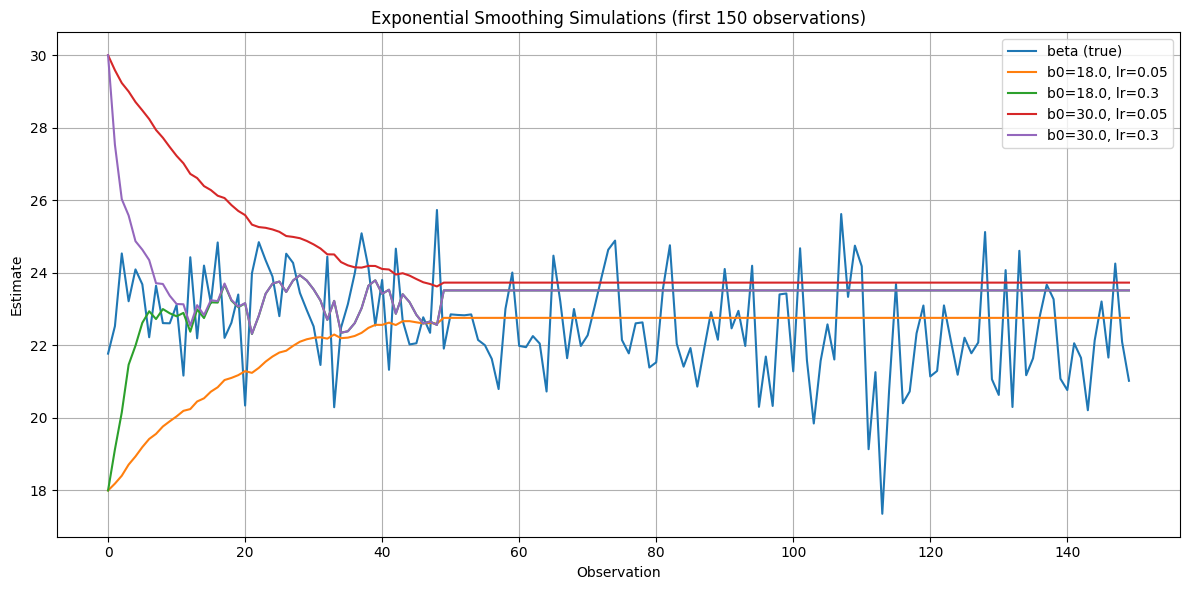

In [1]:
import matplotlib.pyplot as plt

from ml_courses.sim.airco import AircoSimulator

# Get the simulated preferences data
ac = AircoSimulator(seed=123)
df = ac.get_data()
y = df.beta.values

# Set the hyperparameters
b_0 = [18.0, 30.0]  # Initial estimate
lr = [0.05, 0.3]  # Learning rate
max_iter = 50  # Number of iterations

# Run the exponential smoothing algorithm for different configurations
n_sim = 0
for _b_0 in b_0:
    for _lr in lr:
        estimates = [_b_0]
        for i, d in enumerate(y):
            # stopping rule
            if i + 2 > max_iter:
                break
            _b_i = estimates[-1] * (1 - _lr) + float(d) * _lr
            estimates.append(_b_i)
        # If we stopped early, fill the rest with the last estimate
        estimates = estimates + [estimates[-1]] * (len(y) - max_iter)
        df[f"sim{n_sim}"] = estimates
        n_sim += 1

# Visualize the results
# Create labels for the different simulations
sim_labels = [
    f"b0={b_0[0]}, lr={lr[0]}",
    f"b0={b_0[0]}, lr={lr[1]}",
    f"b0={b_0[1]}, lr={lr[0]}",
    f"b0={b_0[1]}, lr={lr[1]}",
]

# Plot the true beta and the simulations
plt.figure(figsize=(12, 6))
plt.plot(df["beta"].iloc[:150], label="beta (true)")
for i, label in enumerate(sim_labels):
    plt.plot(df[f"sim{i}"].iloc[:150], label=label)
plt.xlabel("Observation")
plt.ylabel("Estimate")
plt.title("Exponential Smoothing Simulations (first 150 observations)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

:::{note} 🌍
:icon: false
:class: simple
In dit algoritme spreken we dus over twee _hyper parameters_: $\hat{b}^0$ en $\alpha$. De keuze daarvan heeft duidelijk drastische gevolgen voor de convergentie van het leerproces.
Als we op een bepaald moment de schatting van de model parameter $\hat{b}$ willen vastzetten (zgn. _parameter freezing_), kunnen het algoritme ook uitbreiden met een zgn. _stopping rule_.
Die regel bepaalt de voorwaarde om de updates te stoppen. Dat kan heel simpel door toevoeging van een hyper parameter die het maximum aantal updates bepaalt of door bijvoorbeeld een limiet te zetten op de _online_ update variantie (bv. [](https://doi.org/10.2307%2F1266577))
:::

## _Loss_ functie
De _Loss_ functie is ook gekend onder de namen _Error_ functie en _Cost_ functie. Er wordt in de domeinen van de wiskundige optimalisatie en beslissingstheorie ook soms gesproken over een _objectieve functie_.
Die verwijst ofwel naar een verliesfunctie of zijn tegengestelde vorm. Dan wordt er bijvoorbeeld ook gesproken over een _reward_ functie, _profit_ functie, _utility_ functie, _fitness_ functie, enz.
  
Bij het zoeken naar de optimale waarden voor de parameters in ons model _en/of_ om te evalueren of het leeralgoritme effectief tot _leren_ leidt, moeten we wiskundig kunnen uitdrukken wat _optimaliteit_ in een specifiek geval betekent om de _goodness of fit_ van de oplossing te kunnen uitdrukken - met andere woorden, we moeten de _optimaliteit_ van parameterschattingen op ieder moment in een cijfer kunnen uitdrukken (kwantificeren). We moeten dus een functie beschrijven die optimaliteit uitdrukt. Het doel van het leeralgoritme is om de output van die functie te maximaliseren.  
❗Om wiskundige redenen, draaien we de logica echter om en beschrijven we een functie die de _sub-optimaliteit_ uitdrukt. Die functie trachtten we dan te _minimaliseren_.  
  
(target-loss)=
**De _Loss_ functie is de wiskundige functie die de _sub-optimaliteit_ uitdrukt van parameterschattingen in een bepaalde context. Het doel van het leeralgoritme is om de output van die functie te _minimaliseren_.** Zoals we nog zullen illustreren, betekent dit niet per se dat het leeralgoritme rechtstreeks gebruik maakt van de _Loss_ functie.  
  
(target-batch-algorithm)=
:::{note} 🌍
:icon: false
:class: simple
We nemen terug het geval van ons eenvoudige "airco model" $E(d_i) = b$, waarbij we nu _niet_ kiezen voor een online benadering, maar voor een **_batch_ optimalisatie-algoritme** (**de optimalisatie gebeurt door _tegelijk_ naar _alle_ observaties in de training data te kijken**). Een simpele definitie van optimaliteit hierbij is om op zoek te gaan naar de waarde die de kleinste afwijking heeft ten opzichte van alle observaties. Om in deze context _sub-optimaliteit_ uit te drukken als de output van een _Loss_ functie, wordt hier gekozen voor de zogenaamde **Sum of Squared Errors (SSE)** functie met als algemene vorm:
$$
J_{SSE}(f(\pmb{x}); \pmb{y}) = \sum_{i=1}^M(y_i-f(x_i))^2
$$
Deze formule stelt dat we voor elke door het model voorspelde output, $f(x_i)$, bepalen hoe _ver_ de voorspelling afligt van de werkelijke waarde $y_i$. Deze afstand wordt gekwantificeerd door eerst het verschil tussen de twee waarden te nemen en dit te kwadrateren. De gedachte hierachter is dat kleine fouten overeenkomen met kleine afstanden. Vervolgens worden alle $M$ afstanden over de gehele dataset samengevoegd door ze op te tellen. Dit resulteert in één enkel getal dat aangeeft hoe _slecht_ de huidige parameterwaarden de structuur van de volledige dataset vastlegt. De beste set parameterschattingen minimaliseren de SSE en wordt in dit geval ook de kleinste-kwadratenoplossing (least sum of squares, LSS) genoemd.  
  
In ons voorbeeld krijgt deze _Loss_ functie de eenvoudige vorm:
$$
J_{SSE}(\hat{b}; \pmb{d}) = \sum_{i=1}^M(d_i-\hat{b})^2
$$
Het is eenvoudig te verifiëren dat deze functie geminimaliseerd wordt door het sample (of steekproef-)gemiddelde.
$$
J_{SSE}(\hat{b}; \pmb{d}) = \sum_{i=1}^M(d_i-\frac{\sum_{i=1}^M d_i}{M-1})^2
$$

:::


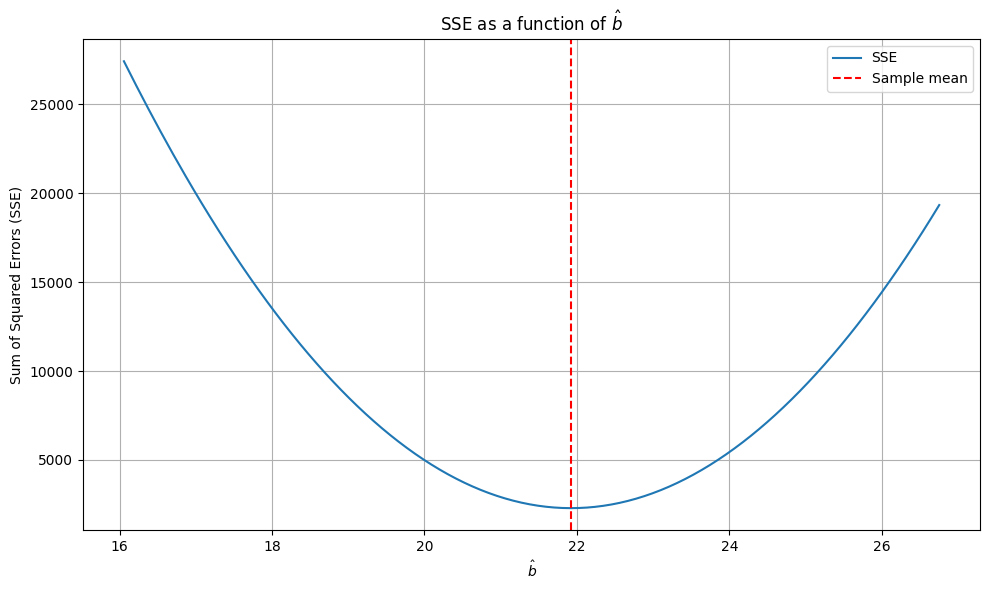

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from ml_courses.sim.airco import AircoSimulator

ac = AircoSimulator()
df = ac.get_data()
d = df.beta.values


# SSE function
def sse(d, b_hat):
    """
    Calculate the sum of squared errors (SSE) between observed values d and estimated values b_hat.

    Parameters
    ----------
    d : array-like
        Observed values.
    b_hat : float
        Estimated value

    Returns
    -------
    float
        The sum of squared errors.
    """
    return sum((d_i - b_hat) ** 2 for d_i in d)


# Range of b_hat values
b_hat_range = np.linspace(np.min(d), np.max(d), 200)
sse_values = [sse(d, b_hat) for b_hat in b_hat_range]

# Sample mean
sample_mean = np.mean(d)

plt.figure(figsize=(10, 6))
plt.plot(b_hat_range, sse_values, label="SSE")
plt.axvline(sample_mean, color="red", linestyle="--", label="Sample mean")
plt.xlabel(r"$\hat{b}$")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("SSE as a function of $\hat{b}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## (On)gebalanceerdde trainingsdata en _bias_
(target-imbalance)=
**Ongebalanceerdheid** van trainingsdata verwijst naar het fenomeen waarbij **bepaalde categorieën** (bv. hond/kat) **of continue waarden** (bv. leeftijden) **over- of ondervertegenwoordigd zijn in de trainingsdata**. Dit kan louter het gevolg zijn van natuurlijke _scheefheid_ ofwel een gevolg van de specifieke manier van trainingsdataverzameling. Dit is een algemeen aandachtspunt bij trainingsdata die op natuurlijke wijze verkregen zijn (bv. verkooptransacties, server logs, enz.). Naargelang de ernst van ongebalanceerdheid, leidt het tot **_statistische bias_**. Dit verwijst naar het fenomeen waarbij **getrainde modellen _systematische_ predictiefouten maken en dus bepaalde _voorkeuren_ hebben ontwikkeld**.  
  
:::{note} 🌍
:icon: false
:class: simple
In extreme gevallen kan een model totaal onbruikbaar worden door ongebalanceerdheid. Stel dat we een dataset krijgen om frauduleuze transacties te voorspellen op basis van een aantal features (bv. IP locatie, volume, enz.). Aangezien we hier met zeldzame events te maken hebben, is de dataset zeer ongebalanceerd met betrekking tot de target klasse (zgn. _class imbalance_) - bijvoorbeeld: 3% frauduleuze transacties versus 97% niet-frauduleuze transacties. Dit impliceert dat een model dat altijd (100%) "niet-frauduleus" voorspelt, een accuraatheid van 97% behaalt - een percentage waar we in andere situaties enkel van kunnen dromen.
  
Ongebalanceerdheid weerspiegelt soms ook sociale ongelijkheden waardoor het risico ontstaat dat we een model creëren dat die ongelijkheden overneemt of zelfs uitvergroot (door bv. systematisch meerderheden te bevooroordelen). Dit is het domein van _ethische ML_.
:::

Om ons in te dekken tegen ongebalanceerdheid is exploratieve data analyse een belangrijke tool. Het kan geremedieerd worden door extra data te verzamelen en/of door _over-/ondersampling_ toe te passen op de trainingsdata.
(target-under-sampling)=
- Bij **_under sampling_ gaan we een random selectie (_subsample_) maken van overgerepresenteerde categorieën of waarden** zodat er een betere balans ontstaat met de ondergerepresenteerde data. Modellen worden dan soms meerdere keren getraind, telkens met een andere _subsample_ om zeker te zijn dat de ondersampling zelf geen artefacten teweeg brengt.
(target-over-sampling)=
- Bij **_over sampling_** worden nieuwe, meer gebalanceerde datasets gemaakt door **random samples uit de ondergerepresenteerde categorieën of waarden _toe te voegen_**. Dit houdt data duplicatie in, maar is in bepaalde gevallen een zeer effectieve strategie tegen _bias_.